In [1]:
import numpy as np
import os
from torchaudio.datasets import SPEECHCOMMANDS
import numpy as np
import librosa
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

2024-05-03 17:06:19.137563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Utiliser CLASStorchaudio.datasets.SPEECHCOMMANDS pour telecharger le dataset
class SpeechCommands(SPEECHCOMMANDS):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, n):
        waveform, sample_rate, label, speaker_id, utterance_number = super().__getitem__(n)
        return waveform, sample_rate, label, speaker_id, utterance_number

    def __len__(self):
        return super().__len__()

# Charger le dataset
def load_dataset():
    dataset = SpeechCommands(root='speech_commands_v0.02', download=True)
    return dataset

def load_data(dataset):
    X = []
    y = []
    for i in range(len(dataset)):
        waveform, sample_rate, label, speaker_id, utterance_number = dataset[i]
        X.append(waveform.numpy())
        y.append(label)
    return X, y

X, y = load_data(load_dataset())



# Utiliser la fonction load_data pour charger les données


100%|██████████| 2.26G/2.26G [04:40<00:00, 8.66MB/s] 


In [2]:
# generate training list = all samples - validation_list - testing_list
if os.path.exists('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/train_list.txt')==False:
    with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/validation_list.txt', 'r') as f:
        val_list = f.readlines()

    with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/testing_list.txt', 'r') as f:
        test_list = f.readlines()

    val_test_list = list(set(test_list+val_list))

    def get_immediate_subdirectories(a_dir):
        return [name for name in os.listdir(a_dir) if os.path.isdir(os.path.join(a_dir, name))]
    def get_immediate_files(a_dir):
        return [name for name in os.listdir(a_dir) if os.path.isfile(os.path.join(a_dir, name))]

    base_path = 'speech_commands_v0.02/SpeechCommands/speech_commands_v0.02'
    all_cmds = get_immediate_subdirectories(base_path)
    all_list = []
    for cmd in all_cmds:
        if cmd != '_background_noise_':
            cmd_samples = get_immediate_files(base_path+'/'+cmd)
            for sample in cmd_samples:
                all_list.append(cmd + '/' + sample+'\n')

    training_list = [x for x in all_list if x not in val_test_list]

    with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/train_list.txt', 'w') as f:
        f.writelines(training_list)

label_set = np.loadtxt('speech_commands_v0.02/SpeechCommands/speechcommands_class_labels_indices.csv', delimiter=',', dtype='str')
label_map = {}
for i in range(1, len(label_set)):
    label_map[eval(label_set[i][2])] = label_set[i][0]
    
print(label_map)


{'backward': '0', 'follow': '1', 'five': '2', 'bed': '3', 'zero': '4', 'on': '5', 'learn': '6', 'two': '7', 'house': '8', 'tree': '9', 'dog': '10', 'stop': '11', 'seven': '12', 'eight': '13', 'down': '14', 'six': '15', 'forward': '16', 'cat': '17', 'right': '18', 'visual': '19', 'four': '20', 'wow': '21', 'no': '22', 'nine': '23', 'off': '24', 'three': '25', 'left': '26', 'marvin': '27', 'yes': '28', 'up': '29', 'sheila': '30', 'happy': '31', 'bird': '32', 'go': '33', 'one': '34'}


In [3]:
#charger les données d'entrainement
X_train = []
y_train = []
with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/train_list.txt', 'r') as f:
    train_list = f.readlines()
    for sample in train_list:
        sample = sample.replace('\n', '')
        # needs to use the full path like 'speech_commands_v0.02/'+ sample
        path = 'speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/'+ sample
        waveform = librosa.load(path, sr=16000)[0]
        label = sample.split('/')[0]
        X_train.append(waveform)
        y_train.append(label)


X_test = []
y_test = []
with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/testing_list.txt', 'r') as f:
    test_list = f.readlines()
    for sample in test_list:
        sample = sample.replace('\n', '')
        path = 'speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/'+ sample
        waveform = librosa.load(path, sr=16000)[0]
        label = sample.split('/')[0]        
        X_test.append(waveform)
        y_test.append(label)

X_val = []
y_val = []
with open('speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/validation_list.txt', 'r') as f:
    val_list = f.readlines()
    for sample in val_list:
        sample = sample.replace('\n', '')
        path = 'speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/'+ sample
        waveform = librosa.load(path, sr=16000)[0]
        label = sample.split('/')[0]
        X_val.append(waveform)
        y_val.append(label)

In [23]:
print(type(label_map['right']))

<class 'numpy.str_'>


In [4]:
#transformer lable map values en entiers
label_map = {k: v for v, k in enumerate(label_map.keys())}


y_train_encoded = np.array([label_map[i] for i in y_train if i in label_map.keys()] )
y_test_encoded = np.array([label_map[i] for i in y_test if i in label_map.keys()])
y_val_encoded = np.array([label_map[i] for i in y_val if i in label_map.keys()])

from keras.utils import to_categorical

num_classes = 35 
y_train_encoded = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_encoded = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_encoded = to_categorical(y_test_encoded, num_classes=num_classes)



In [25]:
print(type(y_train_encoded[0]))

<class 'int'>


/var/folders/j9/536nrb8d6g12rb8p0d0f02ph0000gn/T/ipykernel_1729/1183119728.py:32: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
/var/folders/j9/536nrb8d6g12rb8p0d0f02ph0000gn/T/ipykernel_1729/1183119728.py:35: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D_augmented, ref=np.max), y_axis='log', x_axis='time')


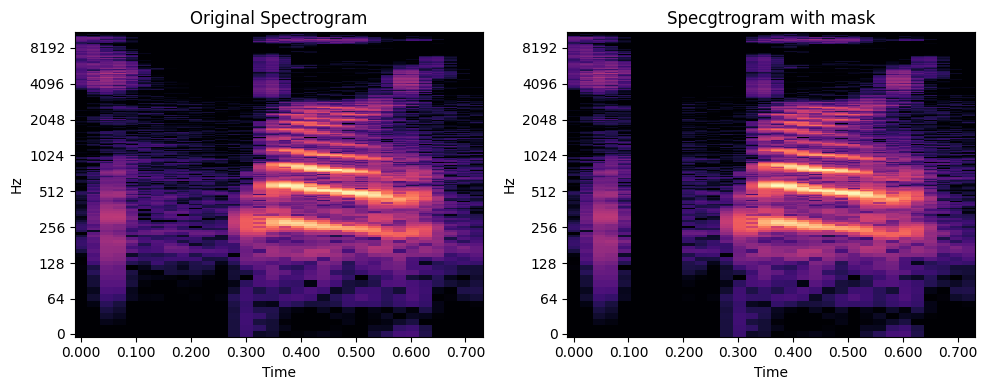

In [67]:
audio_path = 'speech_commands_v0.02/SpeechCommands/speech_commands_v0.02/bird/0a7c2a8d_nohash_0.wav'
y, sr = librosa.load(audio_path, sr=None)
D = librosa.stft(y)


def time_mask(spec, T=5):
    num_time = spec.shape[1]
    t = np.random.uniform(low=0.0, high=num_time)
    t = int(t)
    t_mask = np.random.randint(low=0, high=T)
    mask = np.ones_like(spec)
    mask[:, t:t + t_mask] = 0
    return mask

def freq_mask(spec, F=5):
    num_freq = spec.shape[0]
    f = np.random.uniform(low=0.0, high=num_freq)
    f = int(f)
    f_mask = np.random.randint(low=0, high=F)
    mask = np.ones_like(spec)
    mask[f:f + f_mask, :] = 0
    return mask


# utiliser la fonction time_mask et freq_mask pour creer un masque aleatoire
# appliquer le masque sur le spectrogramme
mask = time_mask(D) * freq_mask(D)
D_augmented = np.multiply(D, mask)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Original Spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(D_augmented, ref=np.max), y_axis='log', x_axis='time')
plt.title('Specgtrogram with mask')
plt.tight_layout()
plt.show()

In [112]:
sr = 16000
def data_agmentation(waveform,param):
    # Ajouter du bruit
    #param = list
    # si param contient 1, ajouter du bruit
    if 1 in param:
        noise = np.random.normal(0, 0.01, waveform.shape)
        waveform = waveform + noise
    # ajouter un décalage
    if 2 in param:
        shift = np.random.randint(low=-sr // 10, high=sr // 10)
        return np.roll(waveform, shift)
    # masking
    if 3 in param:  
        D = librosa.stft(waveform)
        mask = time_mask(D) * freq_mask(D)
        D_augmented = np.multiply(D, mask)
        waveform = librosa.istft(D_augmented)
    
    # Pitch shifting
    if 4 in param:
        n_steps = np.random.randint(low=-5, high=5)
        waveform = librosa.effects.pitch_shift(waveform, sr = sr, n_steps = n_steps)
    
    # Speed Change
    if 5 in param:
        speed_change = np.random.uniform(low=0.9, high=1.1)
        waveform = librosa.effects.time_stretch(waveform, rate=speed_change)
    
    return waveform
    

In [7]:
from librosa.feature import mfcc
def extract_features(waveform, parmetre, bool_augmentation=False):
    # pad the sequence to have the same length for all files (une secondes)
    waveform = torch.tensor(waveform)
    if waveform.shape[0] < 16000:
        waveform = torch.nn.functional.pad(waveform, (0, 16000 - waveform.shape[0]),value=0)
    else:
        waveform = waveform[:16000]

    waveform = waveform.numpy()
    # augment the data
    if bool_augmentation:
        waveform = data_agmentation(waveform,parmetre)
        # extract the features
        if 3 in parmetre or 5 in parmetre:
            waveform = torch.tensor(waveform)
            if waveform.shape[0] < 16000:
                waveform = torch.nn.functional.pad(waveform, (0, 16000 - waveform.shape[0]),value=0)
            else:
                waveform = waveform[:16000]

            waveform = waveform.numpy()
            
        waveform = mfcc(y = waveform,sr=16000, n_mfcc=13,  n_fft=400, hop_length=640,win_length = 320, n_mels=23, fmin=0.0, fmax=8000)
    
    else:
        waveform = mfcc(y = waveform,sr=16000, n_mfcc=13,  n_fft=400, hop_length=640,win_length = 320, n_mels=23, fmin=0.0, fmax=8000)
    
    return waveform
        

def X_trans(X_entry,param, bool_augmentation=False):
    X_entry = np.array([extract_features(waveform,param,bool_augmentation) for waveform in X_entry])
    
    return X_entry

def X_(X_train,X_test,X_val,param,bool_augmentation):
    X_train = X_trans(X_train,param,bool_augmentation)
    X_test =  X_trans(X_test,[],False)
    X_val =  X_trans(X_val,[],False)

    # Normalisation
    scaler = StandardScaler()
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train,X_test,X_val
    


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# matrice de confusion et courbe d'apprentissage
        
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def plot_courbe(model):
    plt.figure(figsize=(12, 4))

    # plot accuracy during training et validation
    plt.subplot(1, 2, 1)
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    # plot loss during training et validation
    plt.subplot(1, 2, 2)
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [9]:
# Sans augmentation
X_train_Non,X_test_Non,X_val_Non = X_(X_train,X_test,X_val,[],True)

In [10]:
print(X_train_Non.shape)

(84843, 338)


In [11]:
# Avec masking
X_train_masking,_,_ = X_(X_train,X_test,X_val,[3],True)


In [12]:
# fusione masking et non masking, shape = (X_train_Non)*2
X_train_masking_aug = np.concatenate((X_train_Non,X_train_masking),axis=0)
print(X_train_masking_aug.shape)


(169686, 338)


In [13]:
Y_train_aug = np.concatenate((y_train_encoded,y_train_encoded),axis=0)

In [14]:
# Avec timeshift
X_train_timeshift,_,_ = X_(X_train,X_test,X_val,[2],True)

In [15]:
X_train_timeshift_aug = np.concatenate((X_train_Non,X_train_timeshift),axis=0)

In [16]:
# Avec bruit
X_train_noise,_,_ = X_(X_train,X_test,X_val,[1],True) 
#X_train_noise = X_trans(X_train,[1],True)

In [17]:
X_train_noise_aug = np.concatenate((X_train_Non,X_train_noise),axis=0)

In [18]:
print(X_train_Non.shape, X_test_Non.shape, X_val_Non.shape)

(84843, 338) (11005, 338) (9981, 338)


In [19]:
# Avec pitch shifting
X_train_Pitch,_,_ = X_(X_train,X_test,X_val,[4],True) 

In [20]:
X_train_Pitch_aug = np.concatenate((X_train_Non,X_train_Pitch),axis=0)

In [21]:
# Avec speed change
X_train_Speed,_,_ = X_(X_train,X_test,X_val,[5],True)

In [22]:
X_train_Speed_aug = np.concatenate((X_train_Non,X_train_Speed),axis=0)

In [23]:
X_train_mask_timeshift_aug = np.concatenate((X_train_Non,X_train_masking,X_train_timeshift),axis=0)

In [24]:
X_train_mask_pitch_aug = np.concatenate((X_train_Non,X_train_masking,X_train_Pitch),axis=0)

In [25]:
X_train_speed_noise_aug = np.concatenate((X_train_Non,X_train_Speed,X_train_noise),axis=0)

In [28]:
Y_train_3 = np.concatenate((y_train_encoded,y_train_encoded,y_train_encoded),axis=0)

In [27]:
X_train_all = np.concatenate((X_train_Non,X_train_masking,X_train_timeshift,X_train_noise,X_train_Pitch,X_train_Speed),axis=0)
Y_train_all = np.concatenate((y_train_encoded,y_train_encoded,y_train_encoded,y_train_encoded,y_train_encoded,y_train_encoded),axis=0)

/var/folders/j9/536nrb8d6g12rb8p0d0f02ph0000gn/T/ipykernel_1729/2628116891.py:8: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
/var/folders/j9/536nrb8d6g12rb8p0d0f02ph0000gn/T/ipykernel_1729/2628116891.py:11: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D_timeshift, ref=np.max), y_axis='log', x_axis='time')


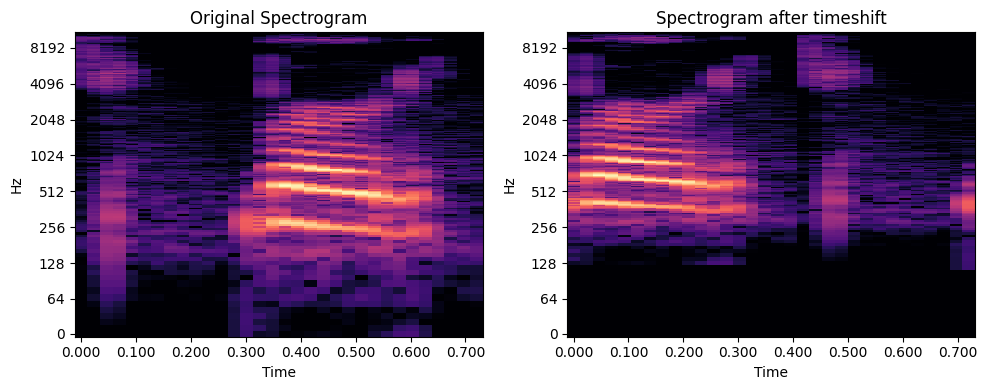

In [80]:
# je veux afficher un example pour chaque augmentation des donnees 
# original et apres timeshift

D_timeshift = data_agmentation(D,[2])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Original Spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(D_timeshift, ref=np.max), y_axis='log', x_axis='time')
plt.title('Spectrogram after timeshift')
plt.tight_layout()
plt.show()

/var/folders/j9/536nrb8d6g12rb8p0d0f02ph0000gn/T/ipykernel_1729/3929096127.py:5: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
/var/folders/j9/536nrb8d6g12rb8p0d0f02ph0000gn/T/ipykernel_1729/3929096127.py:8: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D_noise, ref=np.max), y_axis='log', x_axis='time')


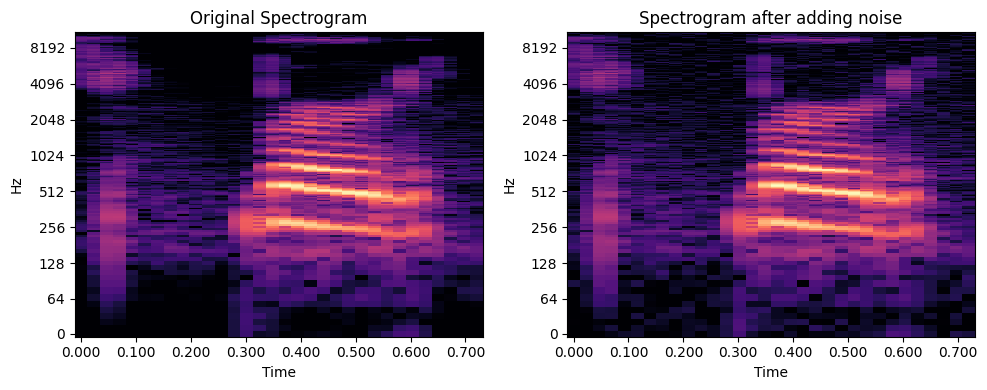

In [62]:
D_noise = data_agmentation(D,[1])

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Original Spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(D_noise, ref=np.max), y_axis='log', x_axis='time')
plt.title('Spectrogram after adding noise')
plt.tight_layout()
plt.show()

/var/folders/j9/536nrb8d6g12rb8p0d0f02ph0000gn/T/ipykernel_1729/3799495112.py:8: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')


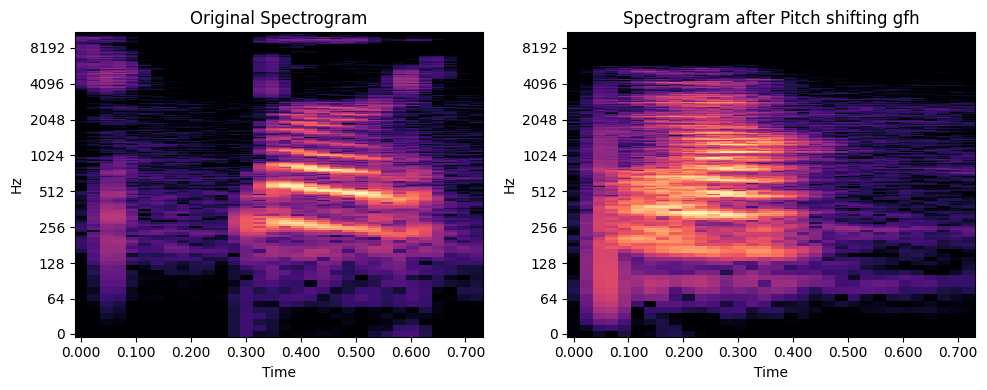

In [125]:

#D_pitch = data_agmentation(y,[4])
D_pitch = librosa.effects.pitch_shift(waveform, sr = sr, n_steps = -10)
#D_shifted = librosa.amplitude_to_db(abs(librosa.stft(D_pitch)), ref=np.max)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Original Spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(abs(librosa.stft(D_pitch)), ref=np.max, top_db=80), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB', vmin=-80, vmax=0)
plt.title('Spectrogram after Pitch shifting gfh')
plt.tight_layout()
plt.show()


/var/folders/j9/536nrb8d6g12rb8p0d0f02ph0000gn/T/ipykernel_1729/353327230.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')


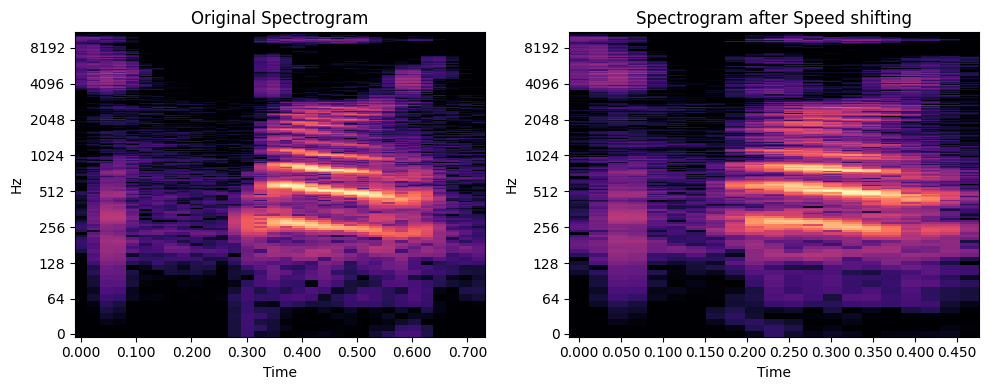

In [109]:
y_fast = librosa.effects.time_stretch(y, rate=1.5)  
D_Speed = librosa.amplitude_to_db(abs(librosa.stft(y_fast)), ref=np.max)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')
plt.title('Original Spectrogram')
plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(abs(librosa.stft(y_fast)), ref=np.max), y_axis='log', x_axis='time')
plt.title('Spectrogram after Speed shifting')
plt.tight_layout()
plt.show()

### Regression Logistic

In [11]:
model_LR1 = LogisticRegression()
model_LR1.fit(X_train, y_train)

y_pred_val = model_LR1.predict(X_val)
y_pred_test = model_LR1.predict(X_test)

print( f"L'acc de validation du modèle Logistic Regression est de : {accuracy_score(y_val, y_pred_val)}")
print( f"L'acc de test du modèle Logistic Regression est de : {accuracy_score(y_test, y_pred_test)}")


############################################Sans Norm################################################################


model_LR2 = LogisticRegression()
model_LR2.fit(X_train_NonNormalized, y_train)

y_pred_val = model_LR2.predict(X_val_NonNormalized)
y_pred_test = model_LR2.predict(X_test_NonNormalized)

print( f"L'acc de validation du modèle Logistic Regression sans normalisation est de : {accuracy_score(y_val, y_pred_val)}")
print( f"L'acc de test du modèle Logistic Regression sans normalisation est de : {accuracy_score(y_test, y_pred_test)}")


L'acc de validation du modèle Logistic Regression est de : 0.4247069431920649
L'acc de test du modèle Logistic Regression est de : 0.39691049522944116
L'acc de validation du modèle Logistic Regression sans normalisation est de : 0.4016631600040076
L'acc de test du modèle Logistic Regression sans normalisation est de : 0.3785552021808269


/Users/zhile/M1-S2/DALAS/selenium_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### SVM

In [7]:
# Creer un modele SVM
from sklearn.svm import SVC
model_SVC1 = SVC()
# ce modele svc ustilise un kernel Gaussien
model_SVC1.fit(X_train_Non, y_train)
y_pred = model_SVC1.predict(X_val)
y_pred_test = model_SVC1.predict(X_test)

print( f"L'acc de validation du modèle SVM est de : {accuracy_score(y_val, y_pred)}")
print( f"L'acc de test du modèle SVM est de : {accuracy_score(y_test, y_pred_test)}")


############################################Sans Norm################################################################

# model_SVC2 = SVC()
# # ce modele svc ustilise un kernel Gaussien
# model_SVC2.fit(X_train_NonNormalized, y_train)

# y_pred = model_SVC2.predict(X_val_NonNormalized)
# y_pred_test = model_SVC2.predict(X_test_NonNormalized)

# print( f"L'acc de validation du modèle SVM sans normalisation est de : {accuracy_score(y_val, y_pred)}")
# print( f"L'acc de test du modèle SVM sans sormalisation est de : {accuracy_score(y_test, y_pred_test)}")

### MLP

In [81]:
# Creer un modele MLP avec 2 couches cachées de 100 et 50 neurones en utilisant pytorch

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(338, 500)
        self.fc2 = nn.Linear(500, 35)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = torch.softmax(self.fc2(x))
        x = self.fc2(x)

        return x
    
def train(model, criterion, optimizer, train_loader):
    model.train()
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    return model


def validate(model, criterion, val_loader):
    model.eval()
    # Trouver best-model
    best_loss = 1000
    best_model = model
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(val_loader):
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            if loss < best_loss:
                best_loss = loss
                best_model = model

    return best_model, best_loss

def test(model, criterion, test_loader,epoch):
    """Test the model on the test set for a number of epoch"""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_loader):
            y_pred = model(X_batch)
            test_loss += criterion(y_pred, y_batch).item()
            pred = y_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y_batch.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)
    print(f"Epoch {epoch}: Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.2f}%)\n")
    return test_accuracy



X_val_tensor = torch.tensor(X_val_Non, dtype=torch.float32)
y_val_tensor = torch.tensor([list(label_map.keys()).index(label) for label in y_val], dtype=torch.long)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32)

X_test_tensor = torch.tensor(X_test_Non, dtype=torch.float32)
y_test_tensor = torch.tensor([list(label_map.keys()).index(label) for label in y_test], dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

In [21]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_Non, dtype=torch.float32)
y_train_tensor = torch.tensor([list(label_map.keys()).index(label) for label in y_train], dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



best_model = model
best_accuracy = 0
for epoch in range(20):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0348, Accuracy: 7445/11005 (0.68%)

Epoch 1: Test set: Average loss: 0.0331, Accuracy: 7751/11005 (0.70%)

Epoch 2: Test set: Average loss: 0.0330, Accuracy: 7849/11005 (0.71%)

Epoch 3: Test set: Average loss: 0.0338, Accuracy: 7882/11005 (0.72%)

Epoch 4: Test set: Average loss: 0.0345, Accuracy: 8033/11005 (0.73%)

Epoch 5: Test set: Average loss: 0.0378, Accuracy: 7994/11005 (0.73%)

Epoch 6: Test set: Average loss: 0.0397, Accuracy: 7907/11005 (0.72%)

Epoch 7: Test set: Average loss: 0.0413, Accuracy: 7983/11005 (0.73%)

Epoch 8: Test set: Average loss: 0.0441, Accuracy: 7982/11005 (0.73%)

Epoch 9: Test set: Average loss: 0.0469, Accuracy: 7979/11005 (0.73%)

Epoch 10: Test set: Average loss: 0.0502, Accuracy: 7923/11005 (0.72%)

Epoch 11: Test set: Average loss: 0.0533, Accuracy: 7943/11005 (0.72%)

Epoch 12: Test set: Average loss: 0.0559, Accuracy: 7894/11005 (0.72%)

Epoch 13: Test set: Average loss: 0.0582, Accuracy: 7898/11005 (0.72%)

Ep

In [84]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_timeshift_aug, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train_aug, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(10):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0309, Accuracy: 7872/11005 (0.72%)

Epoch 1: Test set: Average loss: 0.0292, Accuracy: 8206/11005 (0.75%)

Epoch 2: Test set: Average loss: 0.0310, Accuracy: 8193/11005 (0.74%)

Epoch 3: Test set: Average loss: 0.0316, Accuracy: 8297/11005 (0.75%)

Epoch 4: Test set: Average loss: 0.0332, Accuracy: 8260/11005 (0.75%)

Epoch 5: Test set: Average loss: 0.0352, Accuracy: 8290/11005 (0.75%)

Epoch 6: Test set: Average loss: 0.0374, Accuracy: 8218/11005 (0.75%)

Epoch 7: Test set: Average loss: 0.0396, Accuracy: 8222/11005 (0.75%)

Epoch 8: Test set: Average loss: 0.0429, Accuracy: 8227/11005 (0.75%)

Epoch 9: Test set: Average loss: 0.0444, Accuracy: 8241/11005 (0.75%)

L'acc de test du modèle MLP est de : 0.7488414357110404


In [85]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_masking_aug, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(10):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0326, Accuracy: 7744/11005 (0.70%)

Epoch 1: Test set: Average loss: 0.0337, Accuracy: 7880/11005 (0.72%)

Epoch 2: Test set: Average loss: 0.0356, Accuracy: 8010/11005 (0.73%)

Epoch 3: Test set: Average loss: 0.0390, Accuracy: 8020/11005 (0.73%)

Epoch 4: Test set: Average loss: 0.0451, Accuracy: 7992/11005 (0.73%)

Epoch 5: Test set: Average loss: 0.0488, Accuracy: 7929/11005 (0.72%)

Epoch 6: Test set: Average loss: 0.0531, Accuracy: 7956/11005 (0.72%)

Epoch 7: Test set: Average loss: 0.0588, Accuracy: 7903/11005 (0.72%)

Epoch 8: Test set: Average loss: 0.0651, Accuracy: 7897/11005 (0.72%)

Epoch 9: Test set: Average loss: 0.0679, Accuracy: 7889/11005 (0.72%)

L'acc de test du modèle MLP est de : 0.7168559745570195


In [86]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_noise_aug, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(10):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0331, Accuracy: 7661/11005 (0.70%)

Epoch 1: Test set: Average loss: 0.0316, Accuracy: 7945/11005 (0.72%)

Epoch 2: Test set: Average loss: 0.0320, Accuracy: 8057/11005 (0.73%)

Epoch 3: Test set: Average loss: 0.0334, Accuracy: 8068/11005 (0.73%)

Epoch 4: Test set: Average loss: 0.0347, Accuracy: 8021/11005 (0.73%)

Epoch 5: Test set: Average loss: 0.0367, Accuracy: 8085/11005 (0.73%)

Epoch 6: Test set: Average loss: 0.0380, Accuracy: 8110/11005 (0.74%)

Epoch 7: Test set: Average loss: 0.0408, Accuracy: 7987/11005 (0.73%)

Epoch 8: Test set: Average loss: 0.0425, Accuracy: 8054/11005 (0.73%)

Epoch 9: Test set: Average loss: 0.0453, Accuracy: 8065/11005 (0.73%)

L'acc de test du modèle MLP est de : 0.73284870513403


In [87]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_Pitch_aug, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(10):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0325, Accuracy: 7761/11005 (0.71%)

Epoch 1: Test set: Average loss: 0.0316, Accuracy: 7931/11005 (0.72%)

Epoch 2: Test set: Average loss: 0.0332, Accuracy: 8049/11005 (0.73%)

Epoch 3: Test set: Average loss: 0.0352, Accuracy: 7990/11005 (0.73%)

Epoch 4: Test set: Average loss: 0.0361, Accuracy: 8082/11005 (0.73%)

Epoch 5: Test set: Average loss: 0.0387, Accuracy: 8099/11005 (0.74%)

Epoch 6: Test set: Average loss: 0.0407, Accuracy: 8096/11005 (0.74%)

Epoch 7: Test set: Average loss: 0.0429, Accuracy: 8063/11005 (0.73%)

Epoch 8: Test set: Average loss: 0.0459, Accuracy: 8072/11005 (0.73%)

Epoch 9: Test set: Average loss: 0.0483, Accuracy: 8094/11005 (0.74%)

L'acc de test du modèle MLP est de : 0.7354838709677419


In [88]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_Speed_aug, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(10):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0336, Accuracy: 7609/11005 (0.69%)

Epoch 1: Test set: Average loss: 0.0328, Accuracy: 7902/11005 (0.72%)

Epoch 2: Test set: Average loss: 0.0338, Accuracy: 7991/11005 (0.73%)

Epoch 3: Test set: Average loss: 0.0380, Accuracy: 7925/11005 (0.72%)

Epoch 4: Test set: Average loss: 0.0398, Accuracy: 7988/11005 (0.73%)

Epoch 5: Test set: Average loss: 0.0429, Accuracy: 7965/11005 (0.72%)

Epoch 6: Test set: Average loss: 0.0469, Accuracy: 7954/11005 (0.72%)

Epoch 7: Test set: Average loss: 0.0500, Accuracy: 7926/11005 (0.72%)

Epoch 8: Test set: Average loss: 0.0556, Accuracy: 7816/11005 (0.71%)

Epoch 9: Test set: Average loss: 0.0576, Accuracy: 7919/11005 (0.72%)

L'acc de test du modèle MLP est de : 0.7195820081781009


In [89]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_mask_timeshift_aug, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train_3, dtype= torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(10):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0309, Accuracy: 7971/11005 (0.72%)

Epoch 1: Test set: Average loss: 0.0325, Accuracy: 8027/11005 (0.73%)

Epoch 2: Test set: Average loss: 0.0326, Accuracy: 8214/11005 (0.75%)

Epoch 3: Test set: Average loss: 0.0364, Accuracy: 8188/11005 (0.74%)

Epoch 4: Test set: Average loss: 0.0388, Accuracy: 8193/11005 (0.74%)

Epoch 5: Test set: Average loss: 0.0409, Accuracy: 8199/11005 (0.75%)

Epoch 6: Test set: Average loss: 0.0454, Accuracy: 8208/11005 (0.75%)

Epoch 7: Test set: Average loss: 0.0473, Accuracy: 8145/11005 (0.74%)

Epoch 8: Test set: Average loss: 0.0506, Accuracy: 8156/11005 (0.74%)

Epoch 9: Test set: Average loss: 0.0516, Accuracy: 8241/11005 (0.75%)

L'acc de test du modèle MLP est de : 0.7488414357110404


In [90]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_mask_pitch_aug, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(10):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0314, Accuracy: 7880/11005 (0.72%)

Epoch 1: Test set: Average loss: 0.0335, Accuracy: 7960/11005 (0.72%)

Epoch 2: Test set: Average loss: 0.0343, Accuracy: 8112/11005 (0.74%)

Epoch 3: Test set: Average loss: 0.0381, Accuracy: 8074/11005 (0.73%)

Epoch 4: Test set: Average loss: 0.0408, Accuracy: 8077/11005 (0.73%)

Epoch 5: Test set: Average loss: 0.0443, Accuracy: 8112/11005 (0.74%)

Epoch 6: Test set: Average loss: 0.0479, Accuracy: 8039/11005 (0.73%)

Epoch 7: Test set: Average loss: 0.0520, Accuracy: 8009/11005 (0.73%)

Epoch 8: Test set: Average loss: 0.0551, Accuracy: 8013/11005 (0.73%)

Epoch 9: Test set: Average loss: 0.0570, Accuracy: 8032/11005 (0.73%)

L'acc de test du modèle MLP est de : 0.7298500681508405


In [91]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_speed_noise_aug, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(10):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0332, Accuracy: 7748/11005 (0.70%)

Epoch 1: Test set: Average loss: 0.0308, Accuracy: 8079/11005 (0.73%)

Epoch 2: Test set: Average loss: 0.0325, Accuracy: 8073/11005 (0.73%)

Epoch 3: Test set: Average loss: 0.0336, Accuracy: 8145/11005 (0.74%)

Epoch 4: Test set: Average loss: 0.0374, Accuracy: 8018/11005 (0.73%)

Epoch 5: Test set: Average loss: 0.0381, Accuracy: 8118/11005 (0.74%)

Epoch 6: Test set: Average loss: 0.0391, Accuracy: 8233/11005 (0.75%)

Epoch 7: Test set: Average loss: 0.0413, Accuracy: 8085/11005 (0.73%)

Epoch 8: Test set: Average loss: 0.0434, Accuracy: 8158/11005 (0.74%)

Epoch 9: Test set: Average loss: 0.0460, Accuracy: 8185/11005 (0.74%)

L'acc de test du modèle MLP est de : 0.7437528396183553


In [92]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train_all, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train_all, dtype= torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

best_model = model
best_accuracy = 0
for epoch in range(10):
    model = train(model, criterion, optimizer, train_loader)
    model, val_loss = validate(model, criterion, val_loader)
    accuracy = test(model, criterion, test_loader,epoch)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
    

#utliser le modele pour predire les classes des données de test
y_pred = best_model(X_test_tensor)
y_pred = y_pred.argmax(dim=1)
y_pred = [list(label_map.keys())[label] for label in y_pred.numpy()]
print( f"L'acc de test du modèle MLP est de : {accuracy_score(y_test, y_pred)}")

Epoch 0: Test set: Average loss: 0.0298, Accuracy: 8180/11005 (0.74%)

Epoch 1: Test set: Average loss: 0.0295, Accuracy: 8325/11005 (0.76%)

Epoch 2: Test set: Average loss: 0.0315, Accuracy: 8285/11005 (0.75%)

Epoch 3: Test set: Average loss: 0.0316, Accuracy: 8417/11005 (0.76%)

Epoch 4: Test set: Average loss: 0.0336, Accuracy: 8334/11005 (0.76%)

Epoch 5: Test set: Average loss: 0.0336, Accuracy: 8377/11005 (0.76%)

Epoch 6: Test set: Average loss: 0.0355, Accuracy: 8370/11005 (0.76%)

Epoch 7: Test set: Average loss: 0.0376, Accuracy: 8314/11005 (0.76%)

Epoch 8: Test set: Average loss: 0.0378, Accuracy: 8412/11005 (0.76%)

Epoch 9: Test set: Average loss: 0.0388, Accuracy: 8323/11005 (0.76%)

L'acc de test du modèle MLP est de : 0.7562925942753294


# CNN


In [50]:
class AudioClassifier:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape  
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=self.input_shape),
            MaxPooling2D((1, 1)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((1, 1)),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')   
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, x_train, y_train, batch_size, epochs, validation_data):
        return self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data)

    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model.predict(x)


In [131]:
print("y_train_encoded shape:", y_train_encoded.shape)
print("Type of y_train_encoded:", type(y_train_encoded))


y_train_encoded shape: (84843, 35)
Type of y_train_encoded: <class 'numpy.ndarray'>


In [51]:
X_train_Non_C = X_train_Non.reshape(-1, 13, 26, 1)
X_train_masking_C = X_train_masking_aug.reshape(-1, 13, 26, 1)
X_train_noise_C = X_train_noise_aug.reshape(-1, 13, 26, 1)
X_train_timeshift_C = X_train_timeshift_aug.reshape(-1, 13, 26, 1)
X_train_Pitch_C = X_train_Pitch_aug.reshape(-1, 13, 26, 1)
X_train_Speed_C = X_train_Speed_aug.reshape(-1, 13, 26, 1)

X_val_Non_C = X_val_Non.reshape(-1, 13, 26, 1)
X_test_Non_C = X_test_Non.reshape(-1, 13, 26, 1)

In [48]:
X_train_all_C = X_train_all.reshape(-1, 13, 26, 1)
X_train_mask_pitch_aug_C = X_train_mask_pitch_aug.reshape(-1, 13, 26, 1)
X_train_mask_timeshift_aug_C = X_train_mask_timeshift_aug.reshape(-1, 13, 26, 1)
X_train_speed_noise_aug_C = X_train_speed_noise_aug.reshape(-1, 13, 26, 1)


In [ ]:
classifier_Non_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)
history_Non_C = classifier_Non_C.train(X_train_Non_C, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_Non_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)


Epoch 1/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 400s 149ms/step - accuracy: 0.4631 - loss: 1.8957 - val_accuracy: 0.8641 - val_loss: 0.4539
Epoch 2/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 393s 148ms/step - accuracy: 0.8500 - loss: 0.5000 - val_accuracy: 0.8946 - val_loss: 0.3544
Epoch 3/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 401s 151ms/step - accuracy: 0.8867 - loss: 0.3783 - val_accuracy: 0.9006 - val_loss: 0.3332
Epoch 4/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 401s 151ms/step - accuracy: 0.9062 - loss: 0.3091 - val_accuracy: 0.9068 - val_loss: 0.3143
Epoch 5/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 404s 152ms/step - accuracy: 0.9189 - loss: 0.2663 - val_accuracy: 0.9066 - val_loss: 0.3301
Epoch 6/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 402s 152ms/step - accuracy: 0.9282 - loss: 0.2344 - val_accuracy: 0.9091 - val_loss: 0.3277
Epoch 7/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 404s 152ms/step - accuracy: 0.9314 - loss: 0.2186 - val_accuracy: 0.9045 - val_loss: 0.3303
Epoch 8/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 402s 152ms/step - ac

In [195]:
classifier_Non_C2 = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)
history_Non_C = classifier_Non_C2.train(X_train_Non_C, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_Non_C2.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 200s 74ms/step - accuracy: 0.4711 - loss: 1.8506 - val_accuracy: 0.8649 - val_loss: 0.4538
Epoch 2/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 179s 67ms/step - accuracy: 0.8628 - loss: 0.4685 - val_accuracy: 0.8941 - val_loss: 0.3615
Epoch 3/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 193s 73ms/step - accuracy: 0.8912 - loss: 0.3618 - val_accuracy: 0.9037 - val_loss: 0.3218
Epoch 4/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 206s 78ms/step - accuracy: 0.9102 - loss: 0.3004 - val_accuracy: 0.9010 - val_loss: 0.3508
Epoch 5/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 211s 80ms/step - accuracy: 0.9220 - loss: 0.2607 - val_accuracy: 0.8985 - val_loss: 0.3519
Epoch 6/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 212s 80ms/step - accuracy: 0.9305 - loss: 0.2292 - val_accuracy: 0.8985 - val_loss: 0.3938
Epoch 7/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 208s 78ms/step - accuracy: 0.9364 - loss: 0.2121 - val_accuracy: 0.9075 - val_loss: 0.3734
Epoch 8/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 210s 79ms/step - accuracy: 

In [ ]:
#matrcie de confusion
y_pred = classifier_Non_C2.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_encoded, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_Non_C)

In [ ]:
classifier_mask_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_mask_C = classifier_mask_C.train(X_train_masking_C, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_mask_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/5
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 764s 143ms/step - accuracy: 0.6019 - loss: 1.3930 - val_accuracy: 0.8925 - val_loss: 0.3686
Epoch 2/5
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 765s 144ms/step - accuracy: 0.8866 - loss: 0.3783 - val_accuracy: 0.9059 - val_loss: 0.3268
Epoch 3/5
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 1047s 197ms/step - accuracy: 0.9159 - loss: 0.2758 - val_accuracy: 0.9064 - val_loss: 0.3522
Epoch 4/5
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 771s 145ms/step - accuracy: 0.9293 - loss: 0.2275 - val_accuracy: 0.9093 - val_loss: 0.3706
Epoch 5/5
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 765s 144ms/step - accuracy: 0.9407 - loss: 0.1967 - val_accuracy: 0.9082 - val_loss: 0.3830
344/344 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.8839 - loss: 0.4620
Test accuracy: 0.8898682594299316


344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


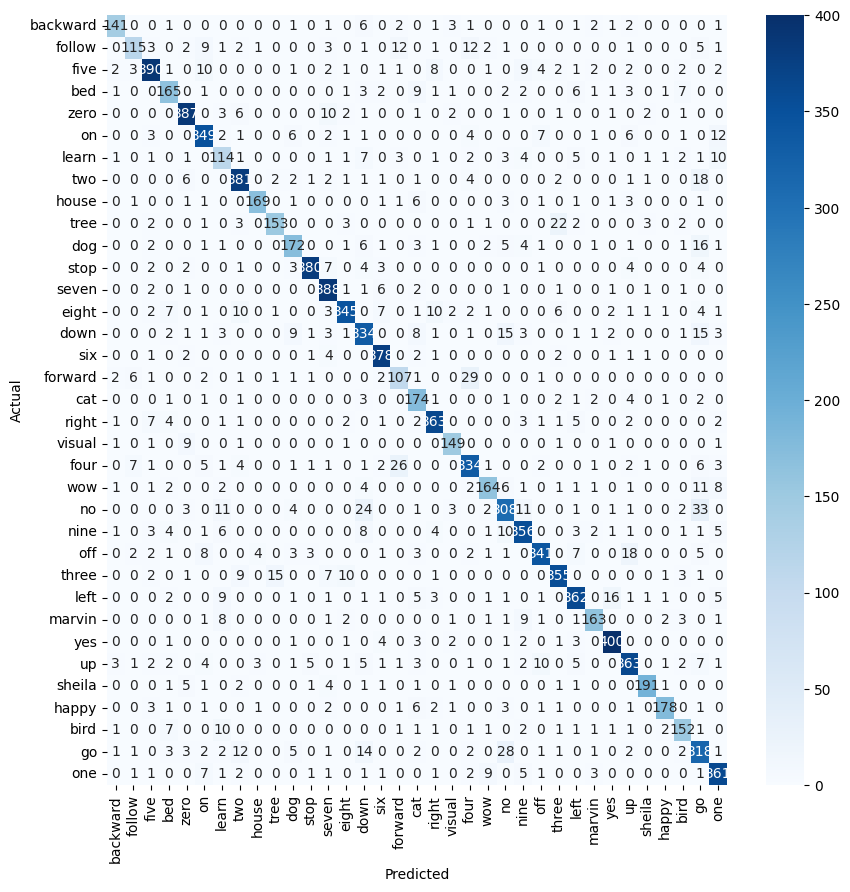

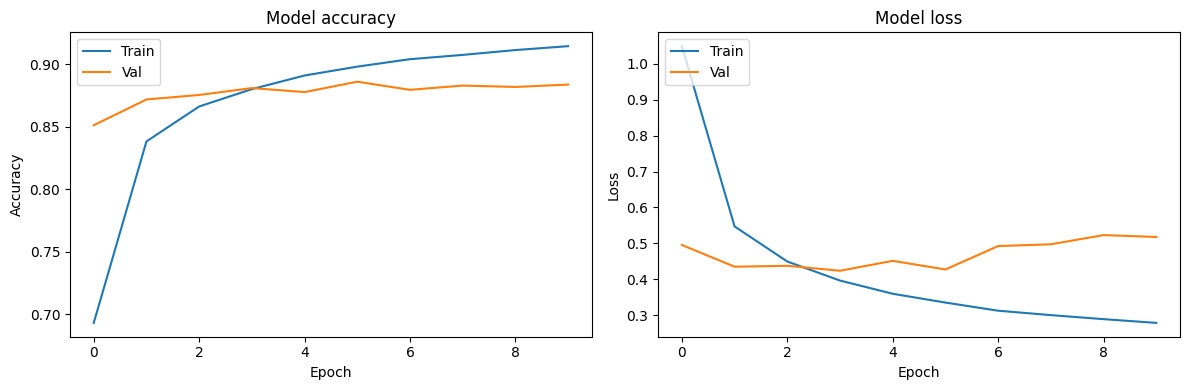

In [125]:
#matrcie de confusion
y_pred = classifier_mask_C.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_mask_C)

In [ ]:
classifier_timeshift_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_timeshift_C=classifier_timeshift_C.train(X_train_timeshift_C, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_timeshift_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 416s 77ms/step - accuracy: 0.5960 - loss: 1.4049 - val_accuracy: 0.8993 - val_loss: 0.3452
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 403s 76ms/step - accuracy: 0.8890 - loss: 0.3825 - val_accuracy: 0.9073 - val_loss: 0.3172
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 416s 79ms/step - accuracy: 0.9083 - loss: 0.3109 - val_accuracy: 0.9119 - val_loss: 0.3174
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 411s 78ms/step - accuracy: 0.9197 - loss: 0.2710 - val_accuracy: 0.9090 - val_loss: 0.3342
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 409s 77ms/step - accuracy: 0.9269 - loss: 0.2458 - val_accuracy: 0.9082 - val_loss: 0.3573
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 425s 80ms/step - accuracy: 0.9310 - loss: 0.2343 - val_accuracy: 0.9113 - val_loss: 0.3412
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 424s 80ms/step - accuracy: 0.9340 - loss: 0.2222 - val_accuracy: 0.9108 - val_loss: 0.3555
Epoch 8/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 417s 79ms/step - accuracy: 

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


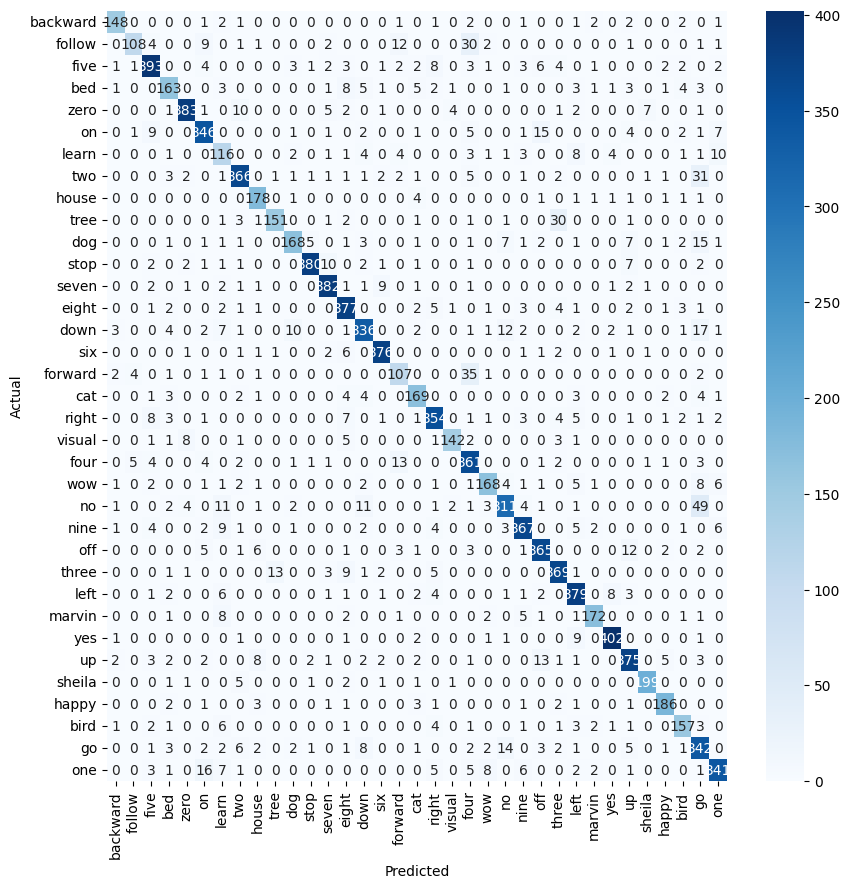

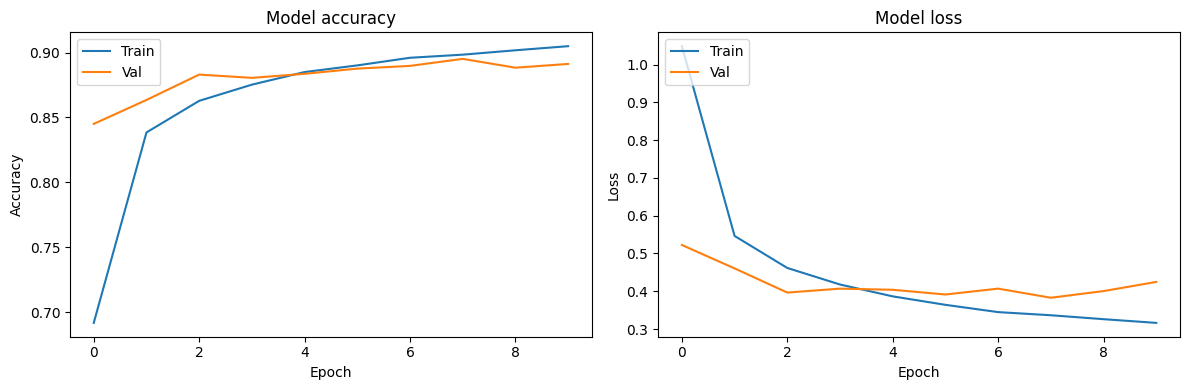

In [116]:
#matrcie de confusion
y_pred = classifier_timeshift_C.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_timeshift_C)

In [ ]:
classifier_noise_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_noise_C=classifier_noise_C.train(X_train_noise_C, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_noise_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 393s 73ms/step - accuracy: 0.5665 - loss: 1.5129 - val_accuracy: 0.8810 - val_loss: 0.4102
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 356s 67ms/step - accuracy: 0.8542 - loss: 0.4948 - val_accuracy: 0.8994 - val_loss: 0.3340
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 418s 74ms/step - accuracy: 0.8795 - loss: 0.4072 - val_accuracy: 0.8978 - val_loss: 0.3465
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 389s 73ms/step - accuracy: 0.8900 - loss: 0.3685 - val_accuracy: 0.9021 - val_loss: 0.3358
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 426s 80ms/step - accuracy: 0.8994 - loss: 0.3388 - val_accuracy: 0.9079 - val_loss: 0.3304
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 423s 80ms/step - accuracy: 0.9041 - loss: 0.3184 - val_accuracy: 0.9105 - val_loss: 0.3353
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 427s 80ms/step - accuracy: 0.9085 - loss: 0.3087 - val_accuracy: 0.9062 - val_loss: 0.3564
Epoch 8/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 447s 81ms/step - accuracy: 

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


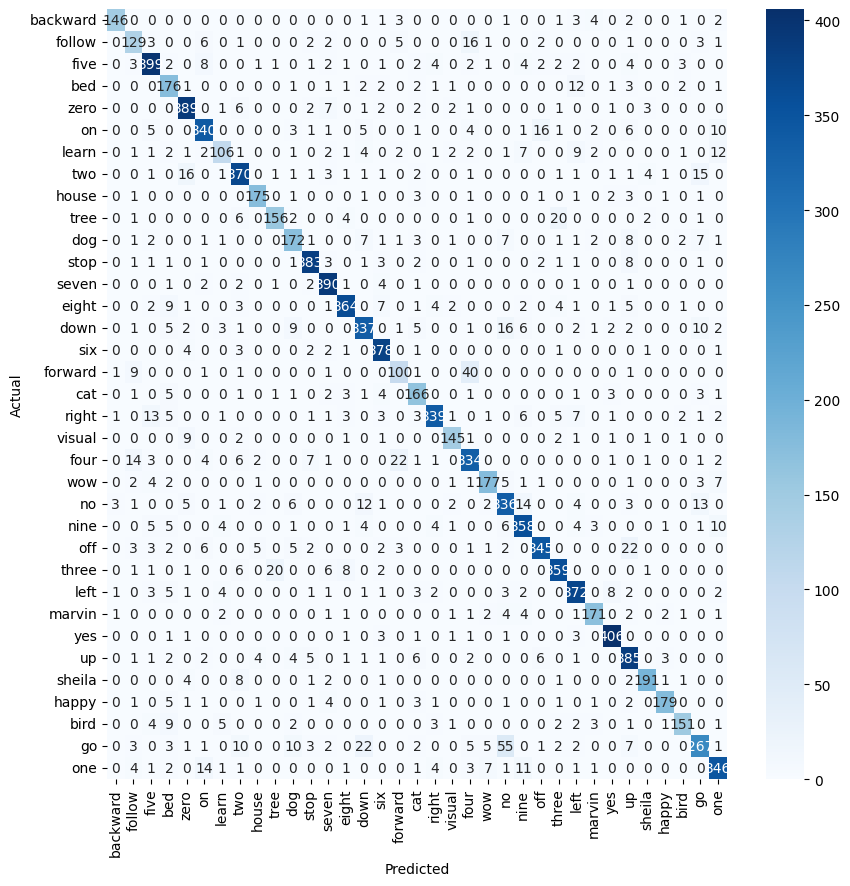

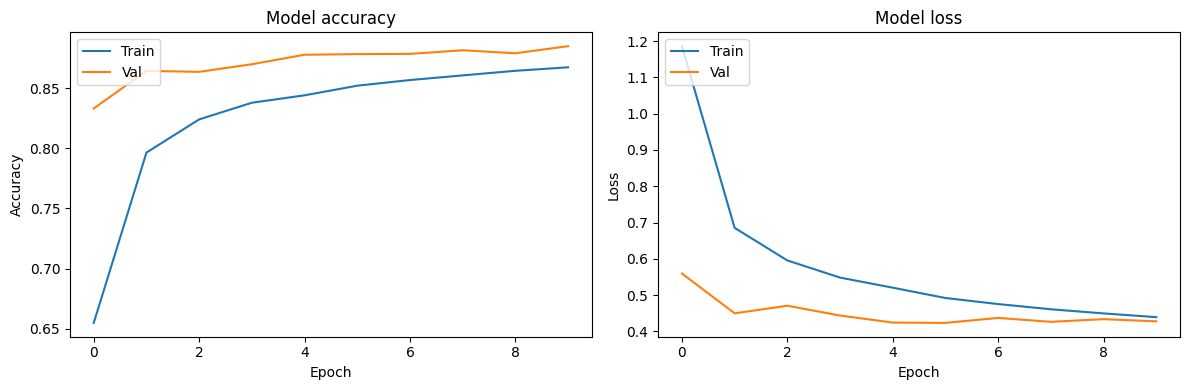

In [118]:
#matrcie de confusion
y_pred = classifier_noise_C.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_noise_C)

In [ ]:
classifier_pitch_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_pitch_C = classifier_pitch_C.train(X_train_Pitch_C, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_pitch_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 740s 137ms/step - accuracy: 0.5803 - loss: 1.4698 - val_accuracy: 0.8922 - val_loss: 0.3644
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 1901s 359ms/step - accuracy: 0.8573 - loss: 0.4788 - val_accuracy: 0.9045 - val_loss: 0.3266
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 756s 143ms/step - accuracy: 0.8856 - loss: 0.3754 - val_accuracy: 0.9074 - val_loss: 0.3158
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 758s 143ms/step - accuracy: 0.9037 - loss: 0.3173 - val_accuracy: 0.9121 - val_loss: 0.3126
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 763s 144ms/step - accuracy: 0.9115 - loss: 0.2904 - val_accuracy: 0.9174 - val_loss: 0.3030
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 757s 143ms/step - accuracy: 0.9174 - loss: 0.2679 - val_accuracy: 0.9106 - val_loss: 0.3295
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 775s 146ms/step - accuracy: 0.9210 - loss: 0.2590 - val_accuracy: 0.9119 - val_loss: 0.3589
Epoch 8/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 777s 147ms/step - a

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


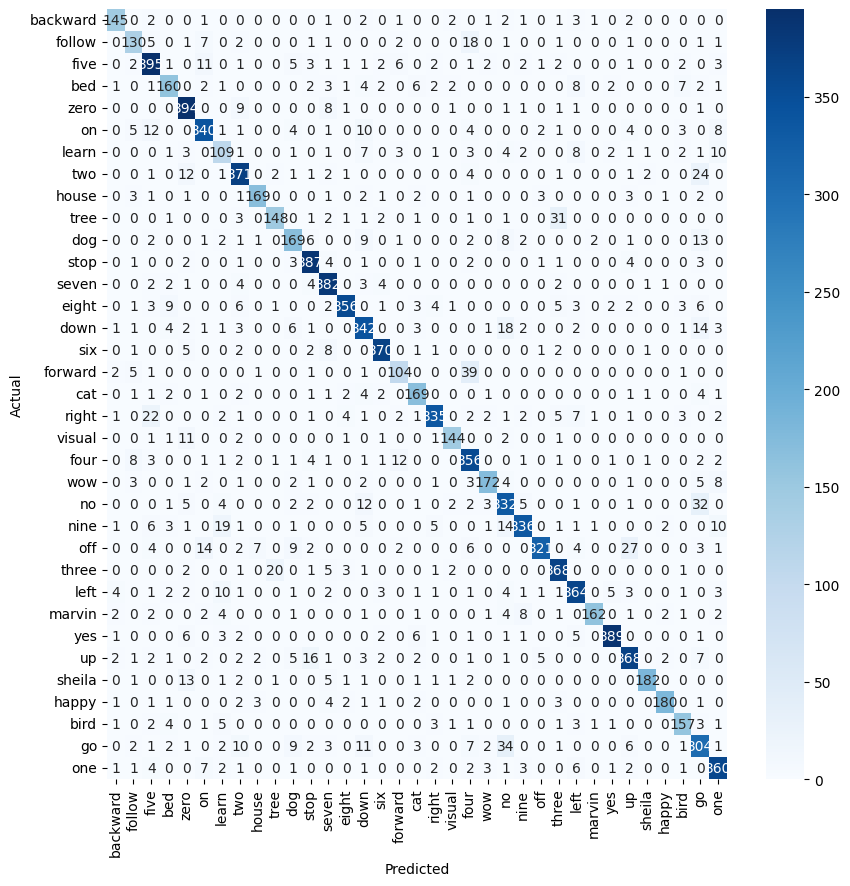

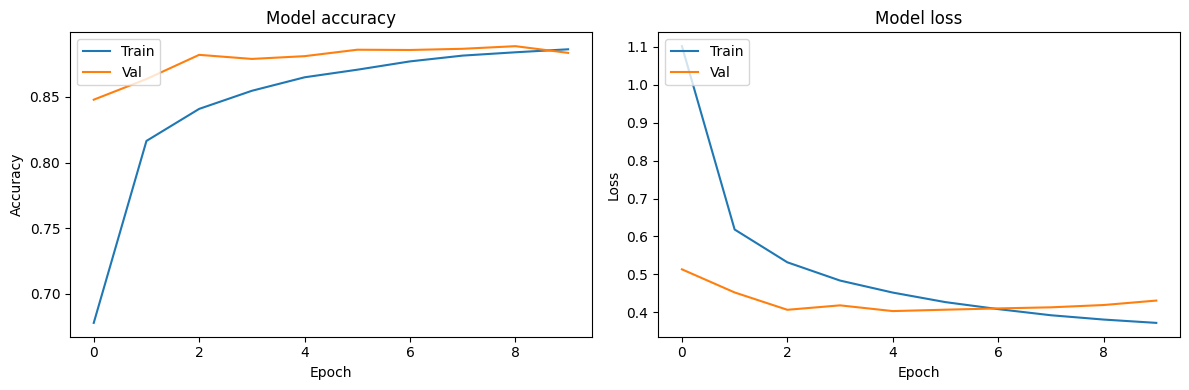

In [127]:
#matrcie de confusion
y_pred = classifier_pitch_C.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_pitch_C)

In [ ]:
classifier_speed_C = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_speed_C=classifier_speed_C.train(X_train_Speed_C, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_speed_C.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 382s 71ms/step - accuracy: 0.5856 - loss: 1.4356 - val_accuracy: 0.8834 - val_loss: 0.3924
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 328s 62ms/step - accuracy: 0.8723 - loss: 0.4304 - val_accuracy: 0.9065 - val_loss: 0.3137
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 323s 61ms/step - accuracy: 0.8961 - loss: 0.3462 - val_accuracy: 0.9020 - val_loss: 0.3380
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 322s 61ms/step - accuracy: 0.9101 - loss: 0.3010 - val_accuracy: 0.9060 - val_loss: 0.3426
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 323s 61ms/step - accuracy: 0.9141 - loss: 0.2837 - val_accuracy: 0.9041 - val_loss: 0.3530
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 332s 63ms/step - accuracy: 0.9219 - loss: 0.2608 - val_accuracy: 0.9053 - val_loss: 0.3681
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 424s 80ms/step - accuracy: 0.9256 - loss: 0.2478 - val_accuracy: 0.9088 - val_loss: 0.3981
Epoch 8/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 418s 79ms/step - accuracy: 

344/344 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


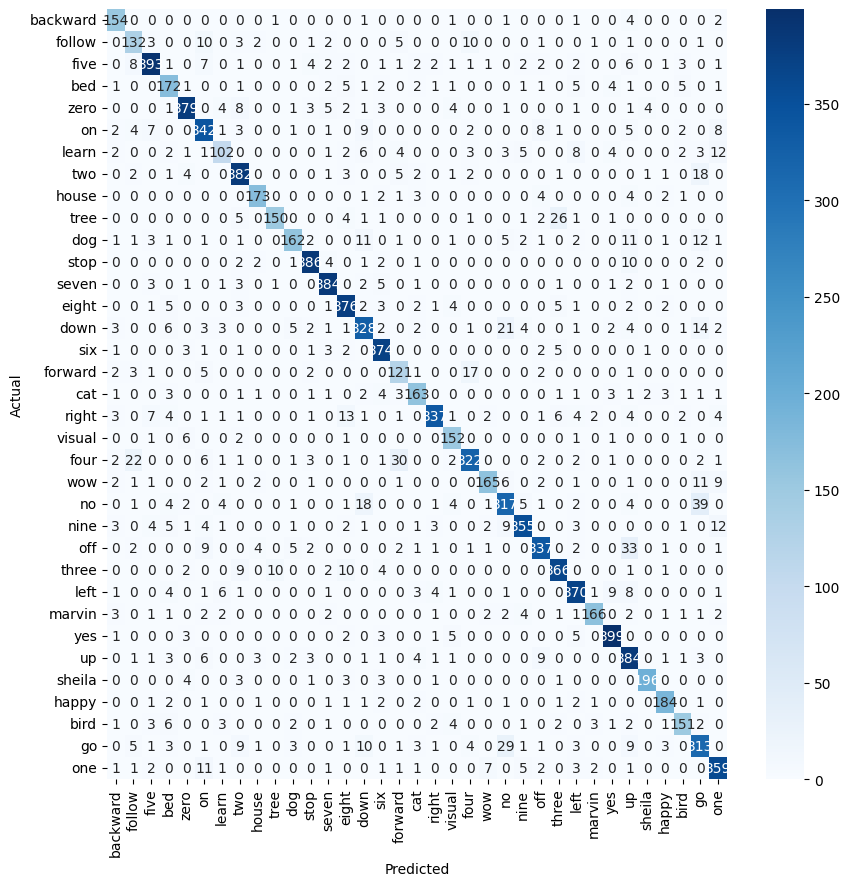

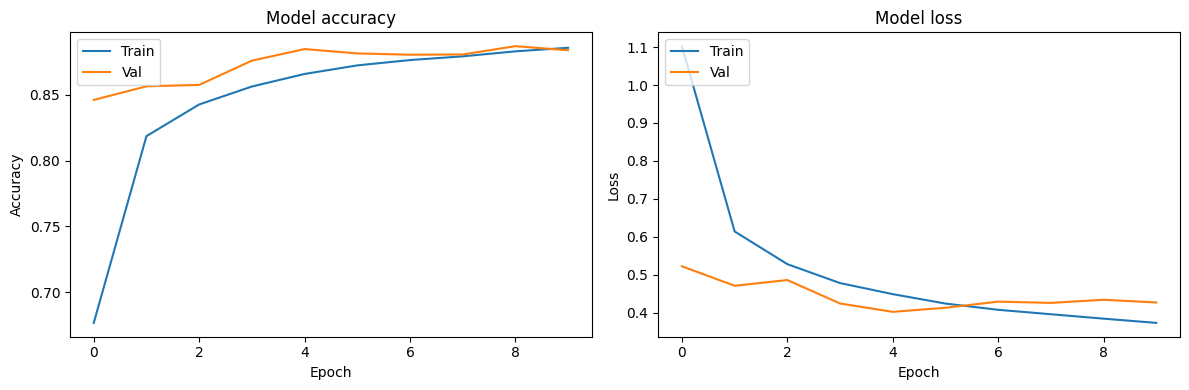

In [123]:
#matrcie de confusion
y_pred = classifier_speed_C.predict(X_test_Non_C)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, label_map)


# courbe de perte
plot_courbe(history_speed_C)

In [54]:
classifier_mask_timeshift = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_mask_timeshift=classifier_mask_timeshift.train(X_train_mask_timeshift_aug_C, Y_train_3, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_mask_timeshift.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 524s 65ms/step - accuracy: 0.6566 - loss: 1.1904 - val_accuracy: 0.8931 - val_loss: 0.3554
Epoch 2/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 530s 67ms/step - accuracy: 0.8945 - loss: 0.3571 - val_accuracy: 0.9069 - val_loss: 0.3356
Epoch 3/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 528s 66ms/step - accuracy: 0.9133 - loss: 0.2930 - val_accuracy: 0.9104 - val_loss: 0.3298
Epoch 4/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 530s 67ms/step - accuracy: 0.9230 - loss: 0.2598 - val_accuracy: 0.9112 - val_loss: 0.3348
Epoch 5/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 507s 64ms/step - accuracy: 0.9282 - loss: 0.2465 - val_accuracy: 0.9119 - val_loss: 0.3336
Epoch 6/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 500s 63ms/step - accuracy: 0.9314 - loss: 0.2342 - val_accuracy: 0.9083 - val_loss: 0.3783
Epoch 7/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 516s 65ms/step - accuracy: 0.9316 - loss: 0.2346 - val_accuracy: 0.9127 - val_loss: 0.3669
Epoch 8/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 521s 65ms/step - accuracy: 

In [55]:
classifier_mask_pitch = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_mask_pitch=classifier_mask_pitch.train(X_train_mask_pitch_aug_C, Y_train_3, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_mask_pitch.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 532s 67ms/step - accuracy: 0.6434 - loss: 1.2350 - val_accuracy: 0.8988 - val_loss: 0.3410
Epoch 2/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 535s 67ms/step - accuracy: 0.8844 - loss: 0.3923 - val_accuracy: 0.9075 - val_loss: 0.3242
Epoch 3/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 543s 68ms/step - accuracy: 0.9038 - loss: 0.3253 - val_accuracy: 0.9108 - val_loss: 0.3315
Epoch 4/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 537s 68ms/step - accuracy: 0.9124 - loss: 0.2961 - val_accuracy: 0.9127 - val_loss: 0.3563
Epoch 5/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 542s 68ms/step - accuracy: 0.9190 - loss: 0.2738 - val_accuracy: 0.9003 - val_loss: 0.4113
Epoch 6/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 540s 68ms/step - accuracy: 0.9210 - loss: 0.2691 - val_accuracy: 0.9134 - val_loss: 0.3847
Epoch 7/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 546s 69ms/step - accuracy: 0.9237 - loss: 0.2620 - val_accuracy: 0.9056 - val_loss: 0.4060
Epoch 8/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 543s 68ms/step - accuracy: 

In [56]:
classifier_noise_speed = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_noise_speed=classifier_noise_speed.train(X_train_speed_noise_aug_C, Y_train_3, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_noise_speed.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 487s 61ms/step - accuracy: 0.6194 - loss: 1.3201 - val_accuracy: 0.8877 - val_loss: 0.3901
Epoch 2/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 485s 61ms/step - accuracy: 0.8593 - loss: 0.4767 - val_accuracy: 0.9002 - val_loss: 0.3443
Epoch 3/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 486s 61ms/step - accuracy: 0.8801 - loss: 0.4049 - val_accuracy: 0.9058 - val_loss: 0.3289
Epoch 4/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 481s 60ms/step - accuracy: 0.8878 - loss: 0.3749 - val_accuracy: 0.9018 - val_loss: 0.3406
Epoch 5/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 485s 61ms/step - accuracy: 0.8948 - loss: 0.3556 - val_accuracy: 0.9060 - val_loss: 0.3322
Epoch 6/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 484s 61ms/step - accuracy: 0.8977 - loss: 0.3440 - val_accuracy: 0.9114 - val_loss: 0.3216
Epoch 7/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 485s 61ms/step - accuracy: 0.8983 - loss: 0.3408 - val_accuracy: 0.9050 - val_loss: 0.3581
Epoch 8/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 489s 61ms/step - accuracy: 

In [57]:
classifier_all = AudioClassifier(input_shape=(13, 26, 1), num_classes=35)  
history_all=classifier_all.train(X_train_all_C, Y_train_all, batch_size=32, epochs=10, validation_data=(X_val_Non_C, y_val_encoded))

test_loss, test_accuracy = classifier_all.evaluate(X_test_Non_C, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 981s 62ms/step - accuracy: 0.7090 - loss: 1.0072 - val_accuracy: 0.9081 - val_loss: 0.3114
Epoch 2/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 982s 62ms/step - accuracy: 0.8801 - loss: 0.4082 - val_accuracy: 0.9199 - val_loss: 0.2854
Epoch 3/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 974s 61ms/step - accuracy: 0.8913 - loss: 0.3704 - val_accuracy: 0.9145 - val_loss: 0.3048
Epoch 4/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 978s 61ms/step - accuracy: 0.8974 - loss: 0.3512 - val_accuracy: 0.9139 - val_loss: 0.3116
Epoch 5/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 976s 61ms/step - accuracy: 0.8982 - loss: 0.3471 - val_accuracy: 0.9121 - val_loss: 0.3242
Epoch 6/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 977s 61ms/step - accuracy: 0.9005 - loss: 0.3409 - val_accuracy: 0.9182 - val_loss: 0.3285
Epoch 7/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 996s 63ms/step - accuracy: 0.9004 - loss: 0.3449 - val_accuracy: 0.9142 - val_loss: 0.3292
Epoch 8/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 994s 62ms/s

# LSTM

In [99]:
from keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

class AudioLSTMClassifier:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape  
        self.num_classes = num_classes 
        self.model,self.lr = self.build_model()

    def build_model(self):
        model = Sequential([
        Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=self.input_shape),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.5),
        
        Bidirectional(LSTM(256, return_sequences=True)),
        Dropout(0.5),
        
        Bidirectional(LSTM(256)),
        Dropout(0.5),
        
        #Attention(),
        
        Dense(256, activation='relu'),
        Dropout(0.3),
        
        Dense(num_classes, activation='softmax')
    ])
        
        optimizer = Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001) 
        return model, lr_reduction

    def train(self, x_train, y_train, batch_size, epochs, validation_data):
        return self.model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=[self.lr])

    def evaluate(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model.predict(x)


In [72]:
X_train_Non_LSTM = X_train_Non.reshape(-1, 13, 26)
X_train_masking_LSTM = X_train_masking_aug.reshape(-1, 13, 26)
X_train_noise_LSTM = X_train_noise_aug.reshape(-1, 13, 26)
X_train_timeshift_LSTM = X_train_timeshift_aug.reshape(-1, 13, 26)
X_train_Pitch_LSTM = X_train_Pitch_aug.reshape(-1, 13, 26)
X_train_Speed_LSTM = X_train_Speed_aug.reshape(-1, 13, 26)

X_val_LSTM = X_val_Non.reshape(-1, 13, 26)
X_test_LSTM = X_test_Non.reshape(-1, 13, 26)




In [69]:
X_train_all_LSTM = X_train_all.reshape(-1, 13, 26)
X_train_mask_pitch_aug_LSTM = X_train_mask_pitch_aug.reshape(-1, 13, 26)
X_train_mask_timeshift_aug_LSTM = X_train_mask_timeshift_aug.reshape(-1, 13, 26)
X_train_speed_noise_aug_LSTM = X_train_speed_noise_aug.reshape(-1, 13, 26)

In [162]:
print("Shape of X_train_Non_LSTM:", X_train_Non_LSTM.shape)
print("", X_train_masking_LSTM.shape)
print("Shape of X_val_LSTM:", X_val_LSTM.shape)


Shape of X_train_Non_LSTM: (84843, 13, 26)
 (169686, 13, 26)
Shape of X_val_LSTM: (9981, 13, 26)


In [100]:

classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_Non_LSTM, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))

test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)


Epoch 1/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 134s 46ms/step - accuracy: 0.2444 - loss: 2.6657 - val_accuracy: 0.6263 - val_loss: 1.2701 - learning_rate: 0.0010
Epoch 2/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 157s 59ms/step - accuracy: 0.5439 - loss: 1.5574 - val_accuracy: 0.6783 - val_loss: 1.0860 - learning_rate: 0.0010
Epoch 3/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 123s 46ms/step - accuracy: 0.6095 - loss: 1.3273 - val_accuracy: 0.7098 - val_loss: 0.9810 - learning_rate: 0.0010
Epoch 4/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 115s 43ms/step - accuracy: 0.6424 - loss: 1.2296 - val_accuracy: 0.7260 - val_loss: 0.9309 - learning_rate: 0.0010
Epoch 5/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 116s 44ms/step - accuracy: 0.6579 - loss: 1.1723 - val_accuracy: 0.7382 - val_loss: 0.8895 - learning_rate: 0.0010
Epoch 6/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 114s 43ms/step - accuracy: 0.6759 - loss: 1.1071 - val_accuracy: 0.7455 - val_loss: 0.8655 - learning_rate: 0.0010
Epoch 7/10
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 118s 45ms/step -

In [180]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_noise_LSTM, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 267s 48ms/step - accuracy: 0.3424 - loss: 2.3049 - val_accuracy: 0.6863 - val_loss: 1.0641 - learning_rate: 0.0010
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 251s 47ms/step - accuracy: 0.5985 - loss: 1.3716 - val_accuracy: 0.7298 - val_loss: 0.9160 - learning_rate: 0.0010
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 253s 48ms/step - accuracy: 0.6361 - loss: 1.2335 - val_accuracy: 0.7469 - val_loss: 0.8500 - learning_rate: 0.0010
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 251s 47ms/step - accuracy: 0.6650 - loss: 1.1400 - val_accuracy: 0.7593 - val_loss: 0.8192 - learning_rate: 0.0010
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 271s 51ms/step - accuracy: 0.6790 - loss: 1.0870 - val_accuracy: 0.7669 - val_loss: 0.7874 - learning_rate: 0.0010
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 272s 51ms/step - accuracy: 0.6908 - loss: 1.0438 - val_accuracy: 0.7706 - val_loss: 0.7736 - learning_rate: 0.0010
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 270s 51ms/step -

In [101]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_masking_LSTM, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 282s 50ms/step - accuracy: 0.3201 - loss: 2.3707 - val_accuracy: 0.6826 - val_loss: 1.0829 - learning_rate: 0.0010
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 263s 49ms/step - accuracy: 0.6106 - loss: 1.3391 - val_accuracy: 0.7223 - val_loss: 0.9428 - learning_rate: 0.0010
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 260s 49ms/step - accuracy: 0.6562 - loss: 1.1860 - val_accuracy: 0.7404 - val_loss: 0.8777 - learning_rate: 0.0010
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 272s 51ms/step - accuracy: 0.6803 - loss: 1.1056 - val_accuracy: 0.7543 - val_loss: 0.8528 - learning_rate: 0.0010
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 266s 50ms/step - accuracy: 0.6977 - loss: 1.0353 - val_accuracy: 0.7597 - val_loss: 0.8168 - learning_rate: 0.0010
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 268s 51ms/step - accuracy: 0.7139 - loss: 0.9863 - val_accuracy: 0.7633 - val_loss: 0.8054 - learning_rate: 0.0010
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 267s 50ms/step -

In [102]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_timeshift_LSTM, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 280s 50ms/step - accuracy: 0.3270 - loss: 2.3572 - val_accuracy: 0.6861 - val_loss: 1.0705 - learning_rate: 0.0010
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 261s 49ms/step - accuracy: 0.6062 - loss: 1.3546 - val_accuracy: 0.7304 - val_loss: 0.9240 - learning_rate: 0.0010
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 263s 50ms/step - accuracy: 0.6527 - loss: 1.1967 - val_accuracy: 0.7453 - val_loss: 0.8665 - learning_rate: 0.0010
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 266s 50ms/step - accuracy: 0.6799 - loss: 1.1134 - val_accuracy: 0.7578 - val_loss: 0.8200 - learning_rate: 0.0010
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 263s 50ms/step - accuracy: 0.6930 - loss: 1.0605 - val_accuracy: 0.7664 - val_loss: 0.7925 - learning_rate: 0.0010
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 259s 49ms/step - accuracy: 0.7062 - loss: 1.0168 - val_accuracy: 0.7733 - val_loss: 0.7767 - learning_rate: 0.0010
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 265s 50ms/step -

In [103]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_Pitch_LSTM, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 275s 50ms/step - accuracy: 0.3234 - loss: 2.3643 - val_accuracy: 0.6793 - val_loss: 1.1004 - learning_rate: 0.0010
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 255s 48ms/step - accuracy: 0.5985 - loss: 1.3747 - val_accuracy: 0.7224 - val_loss: 0.9496 - learning_rate: 0.0010
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 261s 49ms/step - accuracy: 0.6436 - loss: 1.2195 - val_accuracy: 0.7392 - val_loss: 0.8814 - learning_rate: 0.0010
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 262s 49ms/step - accuracy: 0.6714 - loss: 1.1316 - val_accuracy: 0.7555 - val_loss: 0.8321 - learning_rate: 0.0010
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 258s 49ms/step - accuracy: 0.6901 - loss: 1.0685 - val_accuracy: 0.7599 - val_loss: 0.8106 - learning_rate: 0.0010
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 256s 48ms/step - accuracy: 0.7011 - loss: 1.0274 - val_accuracy: 0.7737 - val_loss: 0.7753 - learning_rate: 0.0010
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 260s 49ms/step -

In [104]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_Speed_LSTM, Y_train_aug, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 277s 50ms/step - accuracy: 0.3290 - loss: 2.3323 - val_accuracy: 0.6815 - val_loss: 1.0739 - learning_rate: 0.0010
Epoch 2/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 260s 49ms/step - accuracy: 0.6117 - loss: 1.3300 - val_accuracy: 0.7181 - val_loss: 0.9582 - learning_rate: 0.0010
Epoch 3/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 257s 49ms/step - accuracy: 0.6628 - loss: 1.1690 - val_accuracy: 0.7430 - val_loss: 0.8792 - learning_rate: 0.0010
Epoch 4/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 256s 48ms/step - accuracy: 0.6820 - loss: 1.0932 - val_accuracy: 0.7537 - val_loss: 0.8403 - learning_rate: 0.0010
Epoch 5/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 258s 49ms/step - accuracy: 0.7002 - loss: 1.0335 - val_accuracy: 0.7545 - val_loss: 0.8322 - learning_rate: 0.0010
Epoch 6/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 259s 49ms/step - accuracy: 0.7131 - loss: 0.9949 - val_accuracy: 0.7646 - val_loss: 0.8014 - learning_rate: 0.0010
Epoch 7/10
5303/5303 ━━━━━━━━━━━━━━━━━━━━ 255s 48ms/step -

In [105]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_mask_pitch_aug_LSTM, Y_train_3, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 431s 53ms/step - accuracy: 0.3828 - loss: 2.1500 - val_accuracy: 0.7013 - val_loss: 0.9959 - learning_rate: 0.0010
Epoch 2/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 420s 53ms/step - accuracy: 0.6288 - loss: 1.2819 - val_accuracy: 0.7396 - val_loss: 0.8884 - learning_rate: 0.0010
Epoch 3/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 423s 53ms/step - accuracy: 0.6692 - loss: 1.1446 - val_accuracy: 0.7548 - val_loss: 0.8245 - learning_rate: 0.0010
Epoch 4/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 420s 53ms/step - accuracy: 0.6900 - loss: 1.0700 - val_accuracy: 0.7684 - val_loss: 0.7894 - learning_rate: 0.0010
Epoch 5/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 447s 56ms/step - accuracy: 0.7066 - loss: 1.0142 - val_accuracy: 0.7724 - val_loss: 0.7741 - learning_rate: 0.0010
Epoch 6/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 511s 57ms/step - accuracy: 0.7191 - loss: 0.9699 - val_accuracy: 0.7757 - val_loss: 0.7693 - learning_rate: 0.0010
Epoch 7/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 451s 57ms/step -

In [106]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_mask_timeshift_aug_LSTM, Y_train_3, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 461s 56ms/step - accuracy: 0.3765 - loss: 2.1685 - val_accuracy: 0.7157 - val_loss: 0.9643 - learning_rate: 0.0010
Epoch 2/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 454s 57ms/step - accuracy: 0.6335 - loss: 1.2626 - val_accuracy: 0.7477 - val_loss: 0.8655 - learning_rate: 0.0010
Epoch 3/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 450s 57ms/step - accuracy: 0.6754 - loss: 1.1236 - val_accuracy: 0.7627 - val_loss: 0.8109 - learning_rate: 0.0010
Epoch 4/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 450s 57ms/step - accuracy: 0.6966 - loss: 1.0519 - val_accuracy: 0.7698 - val_loss: 0.7763 - learning_rate: 0.0010
Epoch 5/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 451s 57ms/step - accuracy: 0.7106 - loss: 0.9963 - val_accuracy: 0.7804 - val_loss: 0.7457 - learning_rate: 0.0010
Epoch 6/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 457s 57ms/step - accuracy: 0.7259 - loss: 0.9460 - val_accuracy: 0.7823 - val_loss: 0.7392 - learning_rate: 0.0010
Epoch 7/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 457s 57ms/step -

In [107]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_speed_noise_aug_LSTM, Y_train_3, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 407s 50ms/step - accuracy: 0.3503 - loss: 2.2589 - val_accuracy: 0.6936 - val_loss: 1.0465 - learning_rate: 0.0010
Epoch 2/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 397s 50ms/step - accuracy: 0.5958 - loss: 1.3858 - val_accuracy: 0.7329 - val_loss: 0.9096 - learning_rate: 0.0010
Epoch 3/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 400s 50ms/step - accuracy: 0.6387 - loss: 1.2472 - val_accuracy: 0.7490 - val_loss: 0.8398 - learning_rate: 0.0010
Epoch 4/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 394s 49ms/step - accuracy: 0.6598 - loss: 1.1704 - val_accuracy: 0.7554 - val_loss: 0.8212 - learning_rate: 0.0010
Epoch 5/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 398s 50ms/step - accuracy: 0.6754 - loss: 1.1192 - val_accuracy: 0.7697 - val_loss: 0.7747 - learning_rate: 0.0010
Epoch 6/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 401s 50ms/step - accuracy: 0.6892 - loss: 1.0693 - val_accuracy: 0.7769 - val_loss: 0.7510 - learning_rate: 0.0010
Epoch 7/10
7955/7955 ━━━━━━━━━━━━━━━━━━━━ 395s 50ms/step -

In [76]:
classifier = AudioLSTMClassifier(input_shape=(13,26), num_classes=35)
classifier.train(X_train_all_LSTM, Y_train_all, batch_size=32, epochs=10, validation_data=(X_val_LSTM, y_val_encoded))


test_loss, test_accuracy = classifier.evaluate(X_test_LSTM, y_test_encoded)
print("Test accuracy:", test_accuracy)

Epoch 1/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 648s 40ms/step - accuracy: 0.4526 - loss: 1.8940 - val_accuracy: 0.7273 - val_loss: 0.9181 - learning_rate: 0.0010
Epoch 2/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 642s 40ms/step - accuracy: 0.6756 - loss: 1.1221 - val_accuracy: 0.7543 - val_loss: 0.8477 - learning_rate: 0.0010
Epoch 3/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 639s 40ms/step - accuracy: 0.6956 - loss: 1.0604 - val_accuracy: 0.7537 - val_loss: 0.8571 - learning_rate: 0.0010
Epoch 4/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 633s 40ms/step - accuracy: 0.7047 - loss: 1.0381 - val_accuracy: 0.7566 - val_loss: 0.8528 - learning_rate: 0.0010
Epoch 5/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 633s 40ms/step - accuracy: 0.7075 - loss: 1.0347 - val_accuracy: 0.7628 - val_loss: 0.8348 - learning_rate: 0.0010
Epoch 6/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 635s 40ms/step - accuracy: 0.7081 - loss: 1.0389 - val_accuracy: 0.7552 - val_loss: 0.8552 - learning_rate: 0.0010
Epoch 7/10
15909/15909 ━━━━━━━━━━━━━━━━━━━━ 63